In [2]:
import torch

print("PyTorch version:", torch.__version__)

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. You have a GPU.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Running on CPU.")


PyTorch version: 2.3.1
CUDA is not available. Running on CPU.


Data Preprocessing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset (assuming you have a dataset in torchvision.datasets)
# Here we use CIFAR10 as an example and treat it as a binary classification problem
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Filter dataset to have only two classes (e.g., 0: airplane, 1: automobile)
binary_classes = [0, 1]
indices = [i for i, label in enumerate(dataset.targets) if label in binary_classes]
dataset.targets = [dataset.targets[i] for i in indices]
dataset.data = dataset.data[indices]

# Split the dataset into training and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


Model Definition

In [5]:
class BinaryClassificationNet(nn.Module):
    def __init__(self):
        super(BinaryClassificationNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

net = BinaryClassificationNet()


Training and Evaluation with Visualization

[Epoch 1, Batch 100] loss: 0.428
[Epoch 1, Batch 200] loss: 0.300
Epoch 1: Train Loss: 0.216, Test Loss: 0.242, Train Accuracy: 0.911, Test Accuracy: 0.899
[Epoch 2, Batch 100] loss: 0.226
[Epoch 2, Batch 200] loss: 0.194
Epoch 2: Train Loss: 0.137, Test Loss: 0.171, Train Accuracy: 0.950, Test Accuracy: 0.930
[Epoch 3, Batch 100] loss: 0.156
[Epoch 3, Batch 200] loss: 0.131
Epoch 3: Train Loss: 0.107, Test Loss: 0.161, Train Accuracy: 0.959, Test Accuracy: 0.935
[Epoch 4, Batch 100] loss: 0.101
[Epoch 4, Batch 200] loss: 0.112
Epoch 4: Train Loss: 0.081, Test Loss: 0.137, Train Accuracy: 0.974, Test Accuracy: 0.948
[Epoch 5, Batch 100] loss: 0.088
[Epoch 5, Batch 200] loss: 0.085
Epoch 5: Train Loss: 0.045, Test Loss: 0.146, Train Accuracy: 0.985, Test Accuracy: 0.948
[Epoch 6, Batch 100] loss: 0.057
[Epoch 6, Batch 200] loss: 0.056
Epoch 6: Train Loss: 0.031, Test Loss: 0.152, Train Accuracy: 0.990, Test Accuracy: 0.951
[Epoch 7, Batch 100] loss: 0.024
[Epoch 7, Batch 200] loss: 0.03

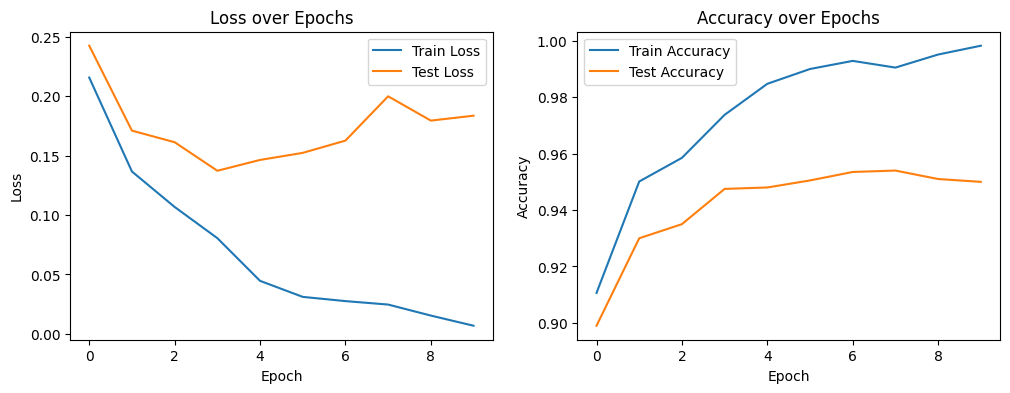

In [6]:
# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Initialize lists to store loss and accuracy values
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            labels = labels.clone().detach().float().view(-1, 1)  # Convert labels to float and reshape
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Training loop
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        labels = labels.clone().detach().float().view(-1, 1)  # Convert labels to float and reshape

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

    # Calculate and store the training and test loss and accuracy
    train_loss = sum([criterion(net(data[0]), data[1].clone().detach().float().view(-1, 1)).item() for data in trainloader]) / len(trainloader)
    test_loss = sum([criterion(net(data[0]), data[1].clone().detach().float().view(-1, 1)).item() for data in testloader]) / len(testloader)
    train_accuracy = calculate_accuracy(trainloader, net)
    test_accuracy = calculate_accuracy(testloader, net)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, Test Accuracy: {test_accuracy:.3f}')

print('Finished Training')

# Save the entire model
MODEL_PATH = './binary_classification_net.pth'
torch.save(net, MODEL_PATH)

# Plot the training and test loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

# Plot the training and test accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


In [7]:
# Save the model's state dictionary
loaded_net = torch.load('./binary_classification_net.pth')
loaded_net.eval()  # Set the model to evaluation mode

MODEL_PATH = './binary_classification_net.pth'
torch.save(loaded_net.state_dict(), MODEL_PATH)